In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import scipy.optimize as opt

import warnings
warnings.filterwarnings("ignore")

# Load data

In [ ]:
file_path = "/content/drive/MyDrive/marketing_campaign.csv"

In [ ]:
df = pd.read_csv(file_path, sep="\t")
df

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Data Cleaning

In [ ]:
# Drop rows with missing values (NaN)
df = df.dropna()

# Print the total number of data points after removing rows with missing values
print("The total number of data-points after removing the rows with missing values are:", len(df))

The total number of data-points after removing the rows with missing values are: 2216


In [ ]:
# Convert "Dt_Customer" to datetime format with specified format
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], format='%d-%m-%Y')

# Initialize an empty list to store date objects
dates = []

# Iterate through each date in "Dt_Customer" column
for i in df["Dt_Customer"]:
    # Extract the date part (datetime.date object)
    i = i.date()
    # Append the date to the list
    dates.append(i)

# Print the newest and oldest customer enrolment dates
print("The newest customer's enrolment date in the records:", max(dates))
print("The oldest customer's enrolment date in the records:", min(dates))

The newest customer's enrolment date in the records: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [ ]:
df["Spent"] = df["MntWines"]+ df["MntFruits"]+ df["MntMeatProducts"]+ df["MntFishProducts"]+ df["MntSweetProducts"]+ df["MntGoldProds"]

In [ ]:
df["Living_With"]=df["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

In [ ]:
df["Children"]=df["Kidhome"]+df["Teenhome"]

df["Family_Size"] = df["Living_With"].replace({"Alone": 1, "Partner":2})+ df["Children"]

In [ ]:
df["Is_Parent"] = np.where(df.Children> 0, 1, 0)

df["Education"]=df["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

df=df.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

In [ ]:
#Dropping some of the redundant features
to_drop = ["Marital_Status", "Kidhome", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID", "Teenhome"]
df_new = df.drop(to_drop, axis=1)

# Summary Statistics

In [ ]:
df_new.columns

Index(['Education', 'Income', 'Dt_Customer', 'Recency', 'Wines', 'Fruits',
       'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',
       'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Spent',
       'Living_With', 'Children', 'Family_Size', 'Is_Parent'],
      dtype='object')

In [ ]:
df_new

,Education,Income,Dt_Customer,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,2012-09-04,58,635,88,546,172,88,88,...,0,0,0,0,1,1617,Alone,0,1,0
1,Graduate,46344.0,2014-03-08,38,11,1,6,2,1,6,...,0,0,0,0,0,27,Alone,2,3,1
2,Graduate,71613.0,2013-08-21,26,426,49,127,111,21,42,...,0,0,0,0,0,776,Partner,0,2,0
3,Graduate,26646.0,2014-02-10,26,11,4,20,10,3,5,...,0,0,0,0,0,53,Partner,1,3,1
4,Postgraduate,58293.0,2014-01-19,94,173,43,118,46,27,15,...,0,0,0,0,0,422,Partner,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,Graduate,61223.0,2013-06-13,46,709,43,182,42,118,247,...,0,0,0,0,0,1341,Partner,1,3,1
2236,Postgraduate,64014.0,2014-06-10,56,406,0,30,0,0,8,...,0,1,0,0,0,444,Partner,3,5,1
2237,Graduate,56981.0,2014-01-25,91,908,48,217,32,12,24,...,0,0,0,0,0,1241,Alone,0,1,0
2238,Postgraduate,69245.0,2014-01-24,8,428,30,214,80,30,61,...,0,0,0,0,0,843,Partner,1,3,1


In [ ]:
df_new.describe()

,Income,Dt_Customer,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,2013-07-10 11:29:27.509025280,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,...,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,607.075361,0.947202,2.592509,0.714350
min,1730.000000,2012-07-30 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,2013-01-16 00:00:00,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,2013-07-08 12:00:00,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,2013-12-31 00:00:00,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2014-06-29 00:00:00,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2525.000000,3.000000,5.000000,1.000000
std,25173.076661,NaN,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,...,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,602.900476,0.749062,0.905722,0.451825


In [ ]:
# Separate numerical and categorical columns
numeric_cols = df_new.select_dtypes(include=[float, int]).columns
categorical_cols = df_new.select_dtypes(include=[object]).columns

In [ ]:
# Summary statistics for numerical columns
numerical_summary = df_new[numeric_cols].describe().T
numerical_summary['skew'] = df_new[numeric_cols].skew()
numerical_summary['kurtosis'] = df_new[numeric_cols].kurtosis()
print("Numerical Summary:")
numerical_summary

Numerical Summary:


,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Income,2216.0,52247.251354,25173.076661,1730.0,35303.0,51381.5,68522.00,666666.0,6.763487,159.636700
Recency,2216.0,49.012635,28.948352,0.0,24.0,49.0,74.00,99.0,0.001648,-1.199777
Wines,2216.0,305.091606,337.327920,0.0,24.0,174.5,505.00,1493.0,1.170720,0.582741
Fruits,2216.0,26.356047,39.793917,0.0,2.0,8.0,33.00,199.0,2.101658,4.054082
Meat,2216.0,166.995939,224.283273,0.0,16.0,68.0,232.25,1725.0,2.025577,5.055477
Fish,2216.0,37.637635,54.752082,0.0,3.0,12.0,50.00,259.0,1.916369,3.076476
Sweets,2216.0,27.028881,41.072046,0.0,1.0,8.0,33.00,262.0,2.103328,4.106141
Gold,2216.0,43.965253,51.815414,0.0,9.0,24.5,56.00,321.0,1.839231,3.156342
NumDealsPurchases,2216.0,2.323556,1.923716,0.0,1.0,2.0,3.00,15.0,2.415272,8.974490
NumWebPurchases,2216.0,4.085289,2.740951,0.0,2.0,4.0,6.00,27.0,1.197037,4.072137


In [ ]:
# Correlation matrix
correlation_matrix = df_new[numeric_cols].corr()
print("Correlation Matrix:")
correlation_matrix

Correlation Matrix:


,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumDealsPurchases,NumWebPurchases,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Spent,Children,Family_Size,Is_Parent
Income,1.000000,-0.003970,0.578650,0.430842,0.584633,0.438871,0.440744,0.325916,-0.083101,0.387878,...,0.184400,0.335943,0.276820,0.087545,-0.027225,0.133047,0.667576,-0.293352,-0.240148,-0.338153
Recency,-0.003970,1.000000,0.015721,-0.005844,0.022518,0.000551,0.025110,0.017663,0.002115,-0.005641,...,0.017566,-0.000482,-0.021061,-0.001400,0.013637,-0.199766,0.020066,0.018290,0.014402,0.002485
Wines,0.578650,0.015721,1.000000,0.387024,0.568860,0.397721,0.390326,0.392731,0.008886,0.553786,...,0.373143,0.473550,0.351417,0.206185,-0.039470,0.246299,0.893136,-0.353748,-0.296388,-0.343094
Fruits,0.430842,-0.005844,0.387024,1.000000,0.547822,0.593431,0.571606,0.396487,-0.134512,0.302039,...,0.006396,0.212871,0.191816,-0.009980,-0.005324,0.122443,0.613249,-0.395901,-0.341154,-0.411963
Meat,0.584633,0.022518,0.568860,0.547822,1.000000,0.573574,0.535136,0.359446,-0.121308,0.307090,...,0.091618,0.376867,0.313076,0.043521,-0.023782,0.237746,0.845884,-0.504545,-0.429592,-0.574931
Fish,0.438871,0.000551,0.397721,0.593431,0.573574,1.000000,0.583867,0.427142,-0.143241,0.299688,...,0.016105,0.196277,0.261608,0.002345,-0.021220,0.108145,0.642371,-0.427841,-0.363341,-0.450318
Sweets,0.440744,0.025110,0.390326,0.571606,0.535136,0.583867,1.000000,0.357450,-0.121432,0.333937,...,0.029313,0.259230,0.245102,0.010188,-0.022641,0.116170,0.607062,-0.389411,-0.330482,-0.402722
Gold,0.325916,0.017663,0.392731,0.396487,0.359446,0.427142,0.357450,1.000000,0.051905,0.407066,...,0.024015,0.181397,0.170132,0.050734,-0.031133,0.140332,0.528708,-0.268918,-0.235846,-0.247433
NumDealsPurchases,-0.083101,0.002115,0.008886,-0.134512,-0.121308,-0.143241,-0.121432,0.051905,1.000000,0.241440,...,0.016077,-0.184253,-0.127374,-0.037981,0.000497,0.003451,-0.065854,0.436076,0.374464,0.388425
NumWebPurchases,0.387878,-0.005641,0.553786,0.302039,0.307090,0.299688,0.333937,0.407066,0.241440,1.000000,...,0.162932,0.141189,0.159292,0.034829,-0.016642,0.151431,0.528973,-0.148871,-0.121296,-0.074008


In [ ]:
# Summary statistics for categorical columns
categorical_summary = df_new[categorical_cols].describe().T
print("Categorical Summary:")
categorical_summary

Categorical Summary:


,count,unique,top,freq
Education,2216,3,Graduate,1116
Living_With,2216,2,Partner,1430


In [ ]:
# Value counts for categorical columns
value_counts = {col: df_new[col].value_counts() for col in categorical_cols}
print("Value Counts for Categorical Columns:")
for col, counts in value_counts.items():
    print(f"\n{col}:\n{counts}")

Value Counts for Categorical Columns:

Education:
Education
Graduate         1116
Postgraduate      846
Undergraduate     254
Name: count, dtype: int64

Living_With:
Living_With
Partner    1430
Alone       786
Name: count, dtype: int64


# Data Visualization

In [ ]:
def plot_selected_features(df, features, hue, title):
    """
    Plots and displays a pair plot for the selected features with customized color preferences.

    Parameters:
    df (DataFrame): The input DataFrame containing customer data.
    features (list of str): List of column names to be included in the pair plot.
    hue (str): The name of the column to be used for hue in the pair plot.

    Returns:
    None: The function displays the plot.
    """
    # Make a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()

    # Convert hue values to 'Yes' and 'No' if they are binary (0 and 1)
    if df_copy[hue].dtype == 'int64':
        df_copy[hue] = df_copy[hue].apply(lambda x: 'Yes' if x == 1 else 'No')

    # Setting up color preferences
    sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
    pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
    cmap = colors.ListedColormap(pallet)

    # Creating the pair plot
    plt.figure(figsize=(20, 12))
    sns.pairplot(df_copy[features], hue=hue, palette=["#682F2F","#F3AB60"])

    # Adding the title
    plt.suptitle(title, y=0.98, fontsize=14)
    plt.show()

<Figure size 2000x1200 with 0 Axes>

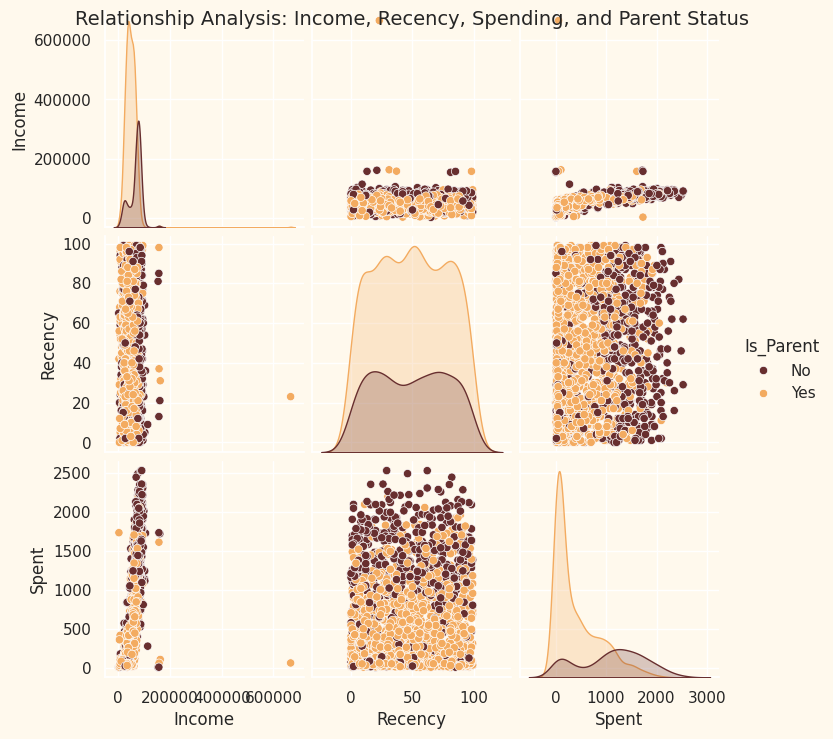

In [ ]:
selected_features = ["Income", "Recency", "Spent", "Is_Parent"]
title = "Relationship Analysis: Income, Recency, Spending, and Parent Status"
plot_selected_features(df_new, selected_features, "Is_Parent", title)

In [ ]:
def plot_avg_spending_by_education(df):
    """
    Plots a bar chart showing the average spending by education level.

    Parameters:
    df (DataFrame): The input DataFrame containing customer data with columns 'Education' and 'Spent'.

    Returns:
    None: The function displays the plot.

    """
    # Calculate the average spending by education level
    education_spending = df.groupby('Education')['Spent'].mean().reset_index()

    # Create the plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    sns.barplot(x='Education', y='Spent', data=education_spending, palette='viridis')  # Create the bar plot
    plt.title('Average Spending by Education Level')  # Set the title of the plot
    plt.xlabel('Education Level')  # Set the x-axis label
    plt.ylabel('Average Spending')  # Set the y-axis label
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
    plt.show()  # Display the plot

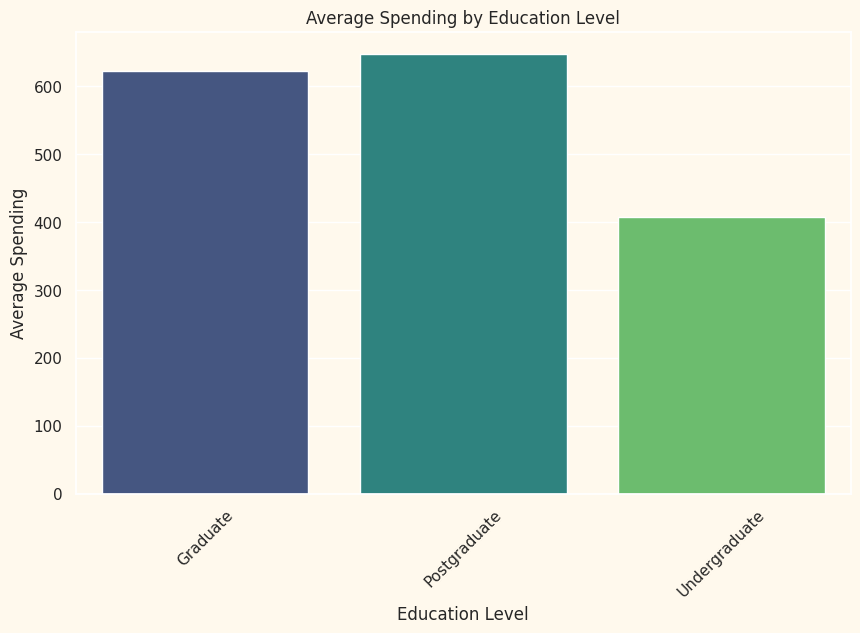

In [ ]:
plot_avg_spending_by_education(df_new)

In [ ]:
def plot_heatmap(df, title):
    """
    Plots and displays a heatmap of correlations between numerical columns.

    Parameters:
    df (DataFrame): The input DataFrame containing customer data.
    title (str): Title for the heatmap plot.

    Returns:
    None: The function displays the plot.
    """
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
    plt.figure(figsize=(20, 20))
    sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()

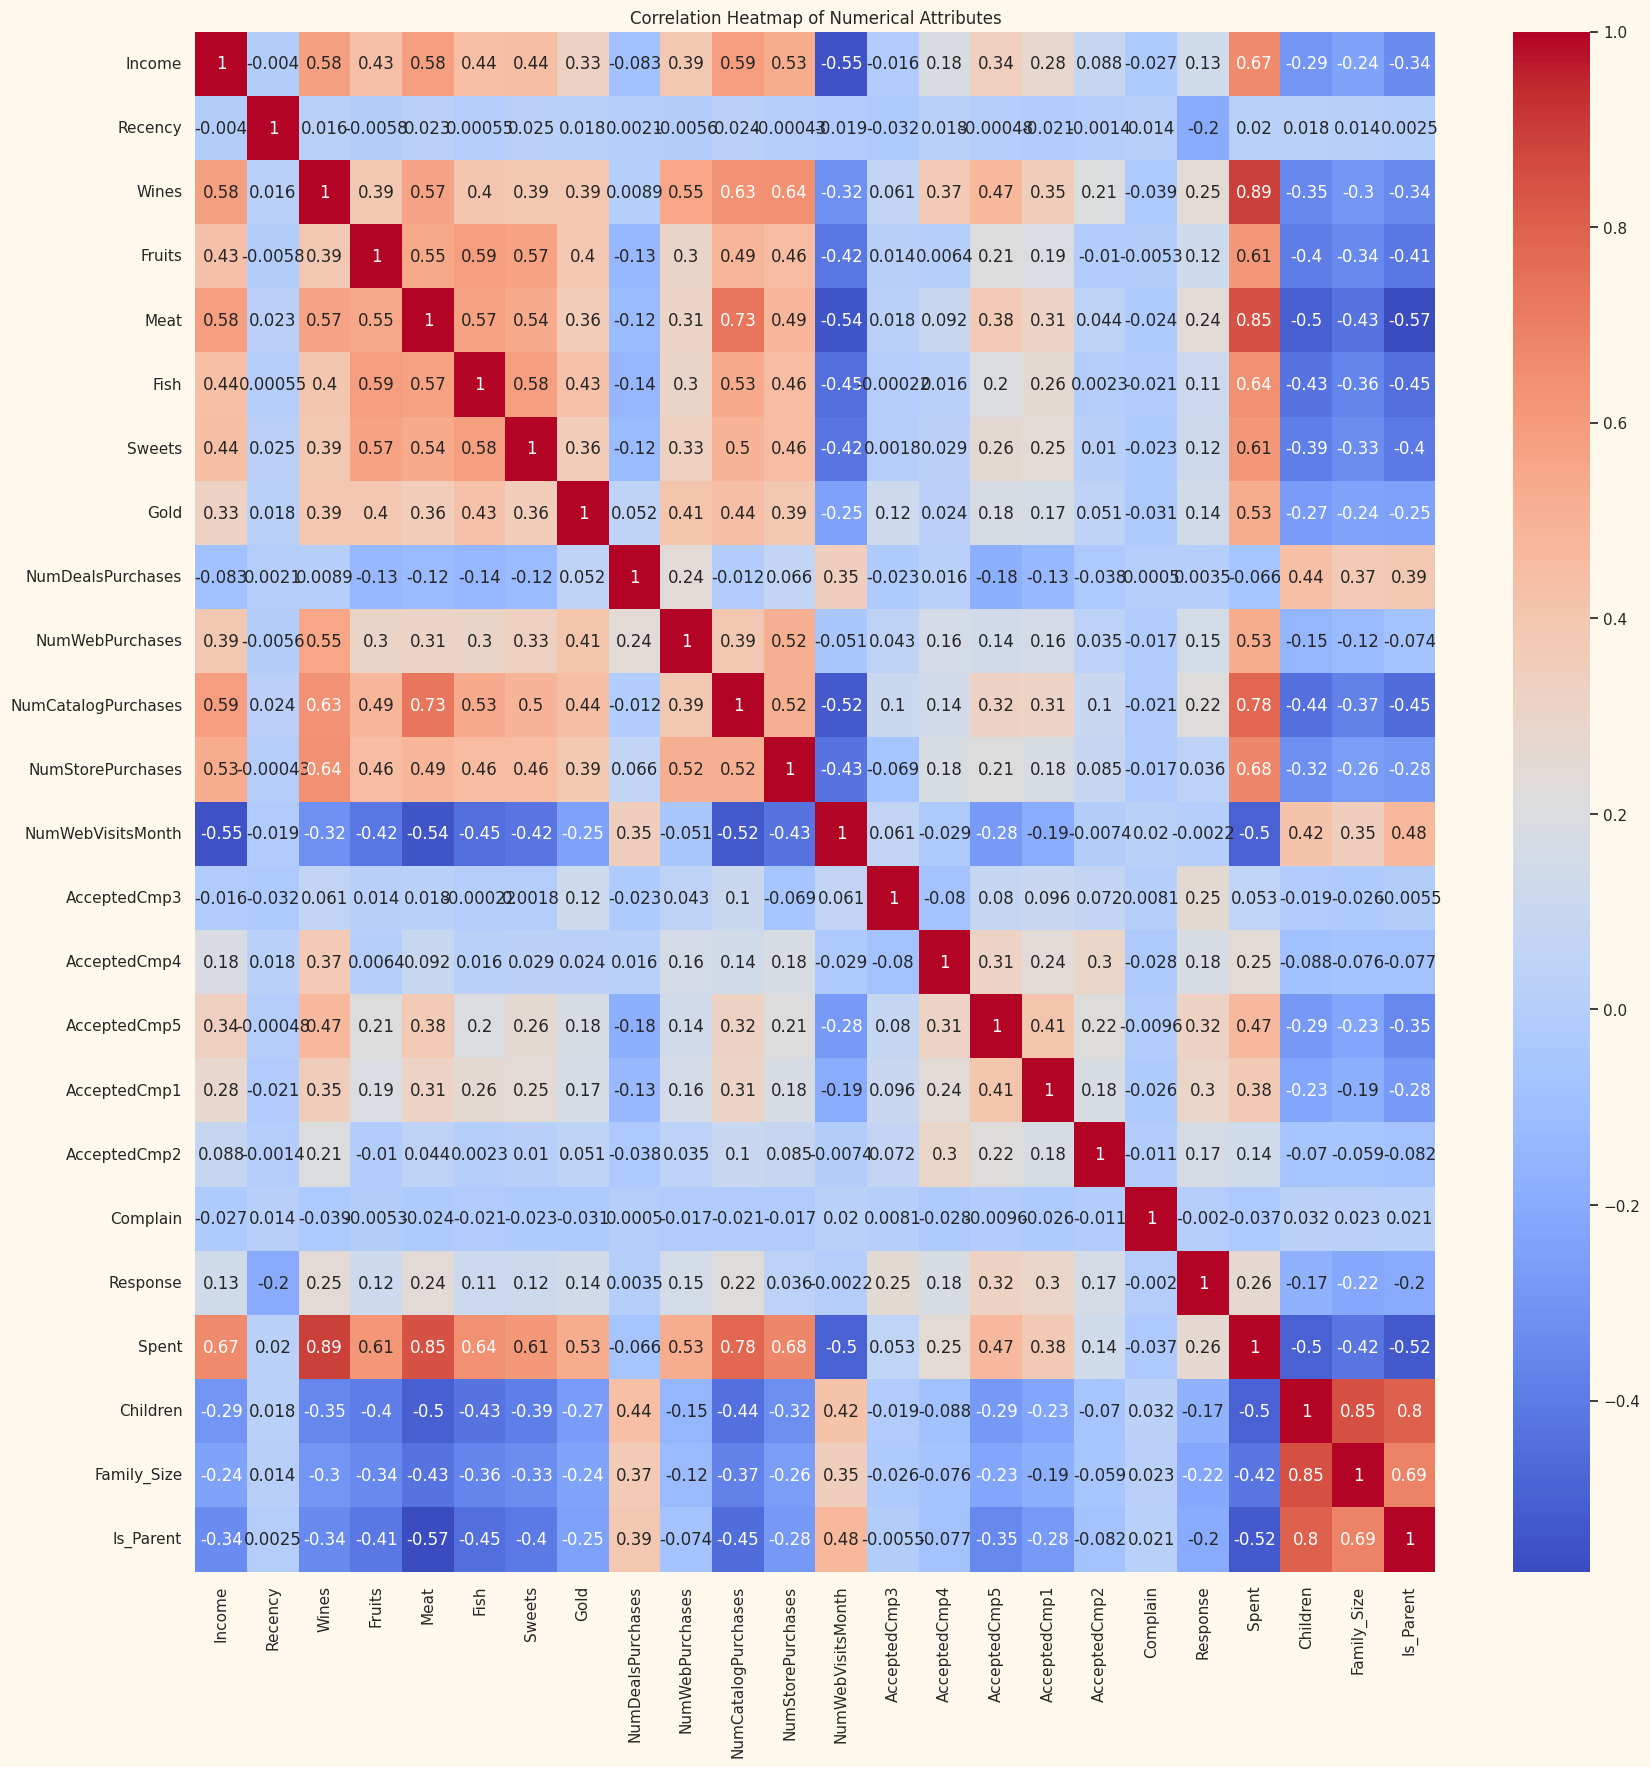

In [ ]:
plot_heatmap(df_new, title='Correlation Heatmap of Numerical Attributes')

# Data Preprocessing

In [ ]:
s = (df_new.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [ ]:
LE=LabelEncoder()
for i in object_cols:
    df_new[i]=df_new[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [ ]:
# Creating a copy of the original dataframe
df1 = df_new.copy()

# Dropping the specified columns
cols_del = ["Dt_Customer",'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']
df1 = df1.drop(cols_del, axis=1)

# Scaling the remaining features
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df1)
scaled_df = pd.DataFrame(scaled_df, columns=df1.columns)

print("All features are now scaled.")

All features are now scaled.


# Dimensionality reduction with PCA

In [ ]:
# scaled_df is your pre-scaled DataFrame
pca = PCA(n_components=3)  # Initialize PCA with 3 components
pca.fit(scaled_df)  # Fit PCA on the scaled data

# Transform the scaled data and create a new DataFrame with the principal components
PCA_ds = pd.DataFrame(pca.transform(scaled_df), columns=["pc1", "pc2", "pc3"])

# Print the first few rows to verify
print(PCA_ds.head())

        pc1       pc2       pc3
0  4.810123 -0.371121  1.777374
1 -2.641296 -0.625598  0.325241
2  2.334041 -0.478096 -0.334893
3 -2.450784 -0.497625 -0.703053
4 -0.447223  1.160765 -0.469389


In [ ]:
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
pc1,2216.0,4.488988e-17,2.748199,-5.649338,-2.402760,-0.888351,2.284340,7.386853
pc2,2216.0,-1.282568e-17,1.512716,-4.022484,-0.987273,-0.130978,0.999013,6.034182
pc3,2216.0,-4.809630e-18,1.142750,-3.483915,-0.889902,-0.228703,0.887937,5.126240


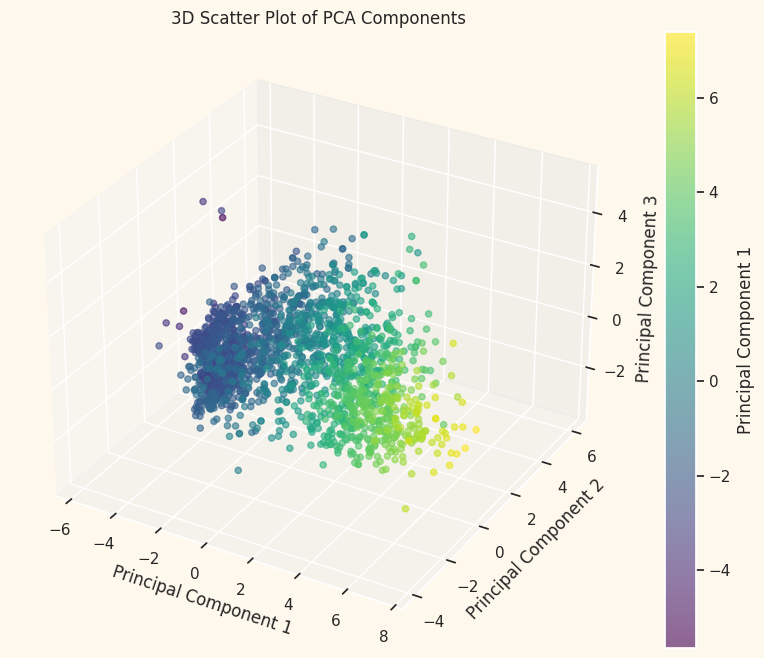

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for each feature
scatter = ax.scatter(PCA_ds['pc1'], PCA_ds['pc2'], PCA_ds['pc3'], c=PCA_ds['pc1'], cmap='viridis', marker='o', alpha=0.6)

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D Scatter Plot of PCA Components')

# Adding color bar
plt.colorbar(scatter, label='Principal Component 1')

plt.show()

# Models

## Elbow Method

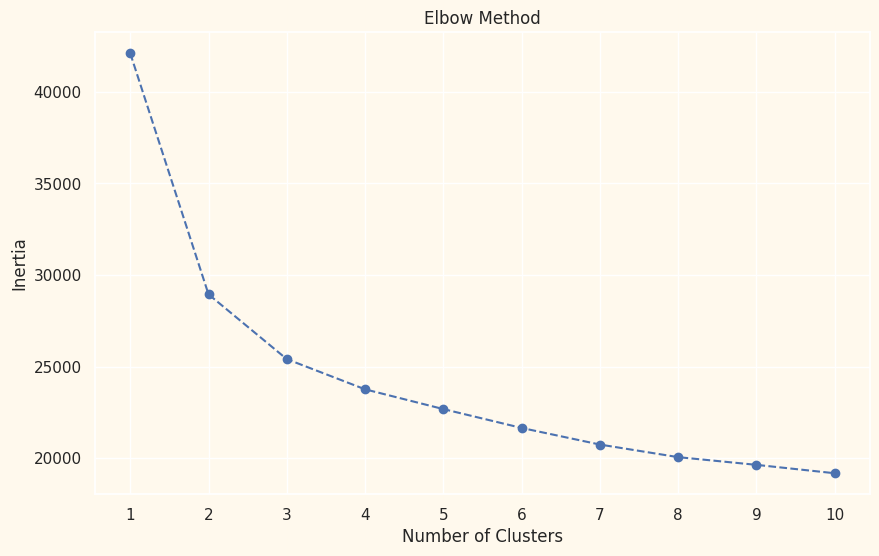

In [ ]:
# Perform KMeans clustering with different number of clusters
max_clusters = 10
inertia = []
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_df)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

## KMeans

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit KMeans model to the standardized data
kmeans.fit(scaled_df)

# Get cluster labels
cluster_labels = kmeans.labels_

# Assign clusters back to the original DataFrame if needed
PCA_ds['K_Cluster'] = cluster_labels

In [ ]:
# Print cluster centers (centroid coordinates)
print("Cluster Centers:")
print(kmeans.cluster_centers_)

Cluster Centers:
[[-0.09577704  0.82338956  0.02059695  0.89621052  0.81333326  0.94591986
   0.85295333  0.81818329  0.64252239 -0.24341153  0.57145875  0.96536149
   0.86204191 -0.730386    1.0954288  -0.06371604 -0.70504624 -0.6167602
  -0.71794765]
 [ 0.05658615 -0.48646777 -0.01216891 -0.52949121 -0.4805264  -0.55886004
  -0.50393438 -0.48339185 -0.37960942  0.14381026 -0.33762423 -0.57034638
  -0.50930401  0.43152023 -0.6471916   0.03764415  0.41654921  0.36438883
   0.42417151]]


In [ ]:
# Print number of points in each cluster
print("\nCluster Sizes:")
print(np.bincount(cluster_labels))


Cluster Sizes:
[ 823 1393]


In [ ]:
# Optionally, inverse transform cluster centers if you want to interpret them in the original space
cluster_centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
print("\nCluster Centers in Original Space:")
print(cluster_centers_original)


Cluster Centers in Original Space:
[[5.45565006e-01 7.29698226e+04 4.96087485e+01 6.07340219e+02
  5.87144593e+01 3.79102066e+02 8.43280680e+01 6.06257594e+01
  7.72503038e+01 1.85540705e+00 5.65127582e+00 5.49574727e+00
  8.60267315e+00 3.54799514e+00 1.26736087e+03 6.14823815e-01
  4.19198056e-01 2.03402187e+00 3.90036452e-01]
 [6.49676956e-01 4.00041242e+04 4.86604451e+01 1.26519742e+02
  7.23833453e+00 4.16812635e+01 1.00524049e+01 7.17946877e+00
  2.43000718e+01 2.60014358e+00 3.16008615e+00 1.00215363e+00
  4.14572864e+00 6.36539842e+00 2.16971285e+02 6.63316583e-01
  1.25915291e+00 2.92246949e+00 9.05958363e-01]]


In [ ]:
silhouette_avg = silhouette_score(scaled_df, cluster_labels)
print(f'K-Means Silhouette Score: {silhouette_avg}')

K-Means Silhouette Score: 0.3146816812315501


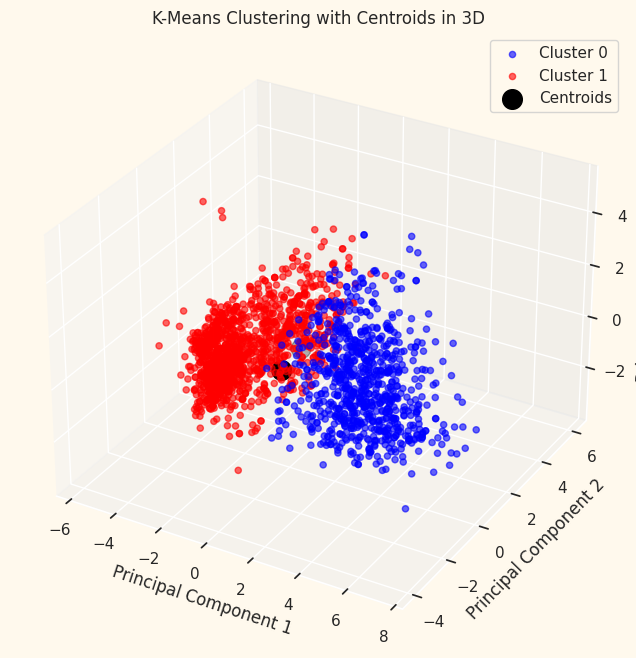

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster
colors = ['blue', 'red']  # Define colors for each cluster
for cluster in range(len(colors)):
    cluster_data = PCA_ds[PCA_ds['K_Cluster'] == cluster]
    ax.scatter(cluster_data['pc1'], cluster_data['pc2'], cluster_data['pc3'], c=colors[cluster], label=f'Cluster {cluster}', alpha=0.6)

# Plot centroids
centroids = kmeans.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='o', s=200, c='black', label='Centroids')

# Set labels and title
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('K-Means Clustering with Centroids in 3D')

# Add legend
ax.legend()

# Show plot
plt.show()


## Agglomerative Clustering


In [ ]:
AC = AgglomerativeClustering(n_clusters=2)

AC.fit(scaled_df)

cluster_labels_ac = AC.labels_

PCA_ds['Ac_Cluster'] = cluster_labels_ac

In [ ]:
silhouette_avg = silhouette_score(scaled_df, cluster_labels_ac)
print(f'Agglomerative Silhouette Score: {silhouette_avg}')

Agglomerative Silhouette Score: 0.3187956674224522


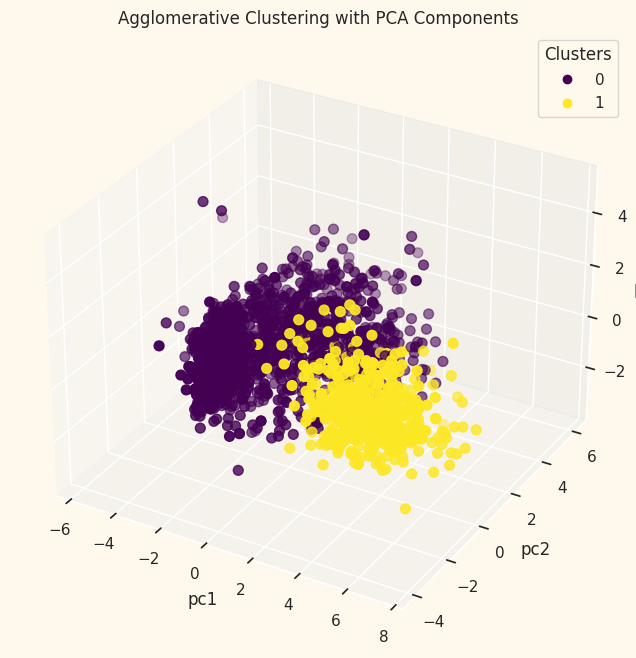

In [ ]:
# Create a figure for 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each cluster with different colors
scatter = ax.scatter(PCA_ds['pc1'], PCA_ds['pc2'], PCA_ds['pc3'], c=PCA_ds['Ac_Cluster'], cmap='viridis', s=50)

# Compute cluster centers
cluster_centers = []
for label in np.unique(PCA_ds['Ac_Cluster']):
    cluster_points = PCA_ds[PCA_ds['Ac_Cluster'] == label][['pc1', 'pc2', 'pc3']]
    cluster_center = cluster_points.mean(axis=0)
    cluster_centers.append(cluster_center.values)

cluster_centers = np.array(cluster_centers)

# Plotting cluster centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], cluster_centers[:, 2], c='red', marker='o', s=200, label='Cluster Centers')

# Setting labels and title
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
ax.set_title('Agglomerative Clustering with PCA Components')

# Adding a legend
plt.legend(*scatter.legend_elements(), title='Clusters')

# Show plot
plt.show()


# Fitting

In [ ]:
df_fit = df_new[['Dt_Customer','Spent']][:100]

In [ ]:
df_fit

,Dt_Customer,Spent
0,2012-09-04,1617
1,2014-03-08,27
2,2013-08-21,776
3,2014-02-10,53
4,2014-01-19,422
...,...,...
104,2014-05-08,1097
105,2013-12-10,29
106,2013-09-24,187
107,2013-02-02,910


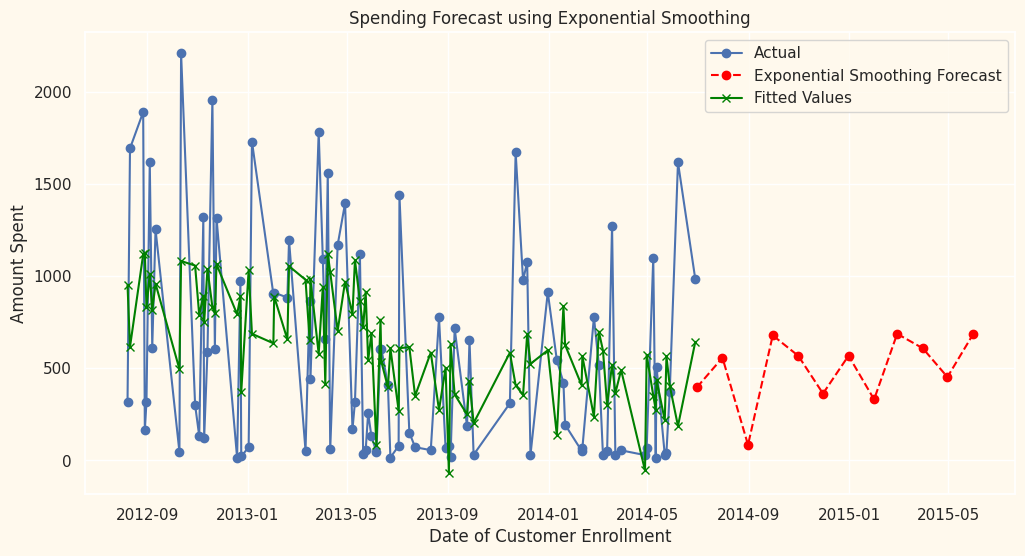

Forecasted Spending for the Next 12 Months:
    Dt_Customer  Forecasted_Spent
90   2014-06-30        396.902618
91   2014-07-31        557.276437
92   2014-08-31         84.630129
93   2014-09-30        678.622674
94   2014-10-31        567.642017
95   2014-11-30        362.912911
96   2014-12-31        568.432321
97   2015-01-31        331.226437
98   2015-02-28        686.958787
99   2015-03-31        608.913524
100  2015-04-30        452.554483
101  2015-05-31        683.577362


In [ ]:
df_fit['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

# Sort by Dt_Customer
df_fit.sort_values('Dt_Customer', inplace=True)

# Ensure there are no duplicate dates in df
df_fit = df_fit[~df_fit['Dt_Customer'].duplicated(keep='first')]

# Extracting relevant columns for forecasting
df_fit = df_fit[['Dt_Customer', 'Spent']]

# Setting index as Dt_Customer for time series data
df_fit.set_index('Dt_Customer', inplace=True)

# Applying Exponential Smoothing
model = ExponentialSmoothing(df_fit['Spent'], seasonal='add', seasonal_periods=12)
model_fit = model.fit()

# Forecasting the next 12 months
forecast = model_fit.forecast(12)

# Creating a DataFrame for forecasted values
last_date = df_fit.index.max()
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=12, freq='M')
forecast_df = pd.DataFrame({'Dt_Customer': forecast_dates, 'Forecasted_Spent': forecast})

# Concatenate original data and forecast data for plotting
df_for_plot = pd.concat([df_fit, forecast_df.set_index('Dt_Customer')], axis=1)

# Plotting actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df_for_plot.index, df_for_plot['Spent'], marker='o', linestyle='-', label='Actual')
plt.plot(df_for_plot.index, df_for_plot['Forecasted_Spent'], marker='o', linestyle='--', color='red', label='Exponential Smoothing Forecast')

# Plotting the fitted values
plt.plot(model_fit.fittedvalues.index, model_fit.fittedvalues, marker='x', linestyle='-', color='green', label='Fitted Values')

plt.title('Spending Forecast using Exponential Smoothing')
plt.xlabel('Date of Customer Enrollment')
plt.ylabel('Amount Spent')
plt.legend()
plt.grid(True)
plt.show()

# Display forecasted values for the next 12 months
print("Forecasted Spending for the Next 12 Months:")
print(forecast_df)